In [2]:
%run utils
import utils

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from tqdm import trange, tqdm
import seaborn as sns
import os

In [4]:
TEST_FILE = "data/splits/val_inference_both.csv"
training_both = "data/splits/training_set_naip_nlcd_both.csv"
val_both = "data/splits/val_inference_both.csv"
IMAGE_COL = "image_fn"
LABEL_COL = "label_fn"
GROUP_COL = "gropu"
ROW = 3

### What are the dimensions of NAIP/NLCD image?

In [5]:
df = pd.read_csv(TEST_FILE)
a = io.imread(df.loc[3, LABEL_COL])
a.shape

(3880, 3880)

In [6]:
df = pd.read_csv(TEST_FILE)
a = io.imread(df.loc[3, IMAGE_COL])
a.shape

(3880, 3880, 4)

### Are validation images also in the training set?

In [7]:
training_both_df = pd.read_csv(training_both)
val_both_df = pd.read_csv(val_both)
print(f"There are {len(training_both_df)} samples in the training set")
print(f"There are {len(val_both_df)} samples in the val set")

There are 4500 samples in the training set
There are 100 samples in the val set


In [8]:
all_in = True
for i in range(len(val_both_df)):
    if val_both_df.loc[i, "image_fn"] not in training_both_df["image_fn"].tolist():
        print(val_both_df.loc[i, "image_fn"])
        all_in = False
        break
    elif val_both_df.loc[i, "label_fn"] not in training_both_df["label_fn"].tolist():
        print(val_both_df.loc[i, "image_fn"])
        all_in = False
        break
all_in

True

### Reading geojson

In [9]:
import geopandas

In [10]:
# the labels annotated by Masa for 3716_naip-2013
gdf = geopandas.read_file("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
gdf.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-76.45065 38.23535, -76.45041 ..."
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-76.42804 38.23022, -76.42678 ..."


In [11]:
gdf['default'].unique()

array(['Impervious', 'Tree Canopy', 'Low Vegetation', 'Water'],
      dtype=object)

In [12]:
gdf.shape

(123, 7)

In [13]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'WGS84 (lat/lon)')

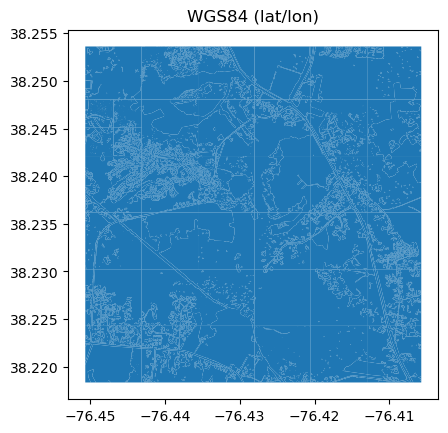

In [14]:
ax = gdf.plot()
ax.set_title("WGS84 (lat/lon)")

<AxesSubplot: >

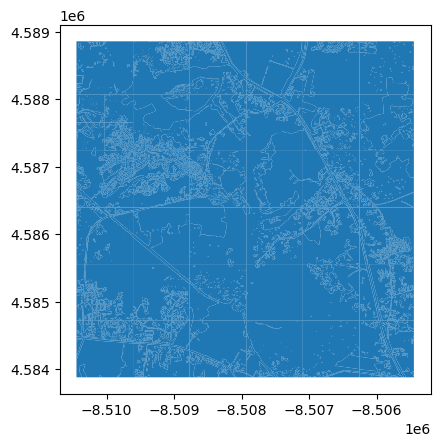

In [15]:
# reproject the original degree-based projection to Mercator
gdf = gdf.to_crs("EPSG:3395")
gdf.plot()

In [16]:
# add an area column
# the area should be in square meters
gdf['area (sq meters)'] = gdf.area
gdf.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry,area (sq meters)
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-8510447.251 4586277.893, -851...",31774.809832
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-8507930.673 4585554.896, -850...",550702.822286


In [17]:
# compute the area percentage of all 4 classes
total_area = gdf['area (sq meters)'].sum()
all_classes = gdf['default'].unique()
percentages = []
for c in all_classes:
    gdf_sub = gdf.loc[gdf['default'] == c]
    sub_class_area_perc = gdf_sub['area (sq meters)'].sum() / total_area
    percentages.append(sub_class_area_perc)

Text(0.5, 1.0, 'Area Percentage of 4 Classes in 3716_naip-2013')

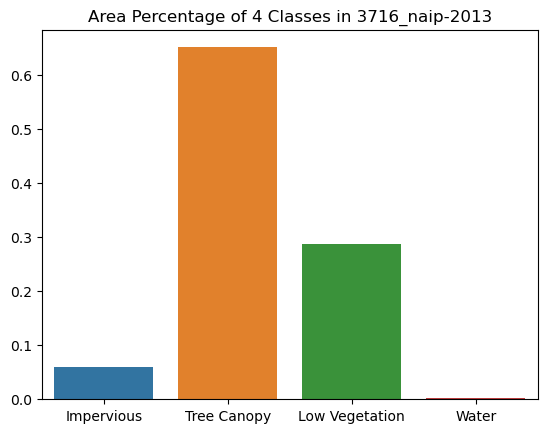

In [18]:
# plot
ax = sns.barplot(x=all_classes, y=percentages)
ax.set_title("Area Percentage of 4 Classes in 3716_naip-2013")

In [19]:
def get_percentages(geojson_path) -> dict:
    gdf = geopandas.read_file(geojson_path)
    gdf = gdf.to_crs("EPSG:3395")
    gdf["area (sq meters)"] = gdf.area
    total_area = gdf['area (sq meters)'].sum()
    all_classes = gdf['default'].unique()
    res = {}
    for c in all_classes:
        gdf_sub = gdf.loc[gdf['default'] == c]
        sub_class_area_perc = gdf_sub['area (sq meters)'].sum() / total_area
        res[c] = sub_class_area_perc
    return res

In [20]:
def get_reduced_class_names(nlcd_label_int) -> str:
    assert nlcd_label_int in utils.NLCD_CLASS.keys()
    for k, v in utils.MAPPING.items():
        if nlcd_label_int in v:
            return k

In [21]:
def create_direct_map():
    res = {}
    for k in utils.NLCD_CLASS.keys():
        for m, n in utils.MAPPING.items():
            if k in n:
                res[k] = m
    return res

In [22]:
def find_image_index(df, image_number, year, col):
    for i in range(len(df)):
        if f"{image_number}_nlcd-{year}" in df.loc[i, col]:
            return i

In [23]:
def calculate_class_percentages(df, image_number, year, col, res) -> dict:
    """Calculate class percentage
    
    Args:
        df: training_both_df
        image_number: str or int, e.g. 3716
        year: str or int, e.g. 2013
        col: str, e.g. "label_fn"
        res: int, e.g. 30 means 30 x 30
    
    Returns:
        dict
    """
    img_index = find_image_index(df, image_number, year, col)
    img = io.imread(df.loc[img_index, col])
    perc_dict = {}
    for m in trange(img.shape[0], desc="1st loop"):
        for n in range(img.shape[1]):
            # "Tree Canopy" / "Water" / ...
            class_label = reduced_map[img[m][n]]
            perc_dict[class_label] = perc_dict.get(class_label, 0) + res ** 2
    for k, v in perc_dict.items():
        perc_dict[k] = v / (img.shape[0] * img.shape[1] * res ** 2)
    return perc_dict

In [24]:
training_both_df = pd.read_csv("data/splits/training_set_naip_nlcd_both.csv")
reduced_map = create_direct_map()
nlcd_percentage_3716_2013 = calculate_class_percentages(training_both_df, "3716", "2013", "label_fn", 30)
nlcd_percentage_3716_2016 = calculate_class_percentages(training_both_df, "3716", "2016", "label_fn", 30)

1st loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [00:50<00:00, 76.74it/s]


In [25]:
masa_annotated_3716_2013 = get_percentages("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
masa_annotated_3716_2017 = get_percentages("data/catalog/labels/data/a4d9c2f2-c09a-4515-b061-4bb854cb4c44.geojson")

In [26]:
masa_annotated_3716_2013

{'Impervious': 0.05906276881854651,
 'Tree Canopy': 0.6514570110188175,
 'Low Vegetation': 0.28749929564818527,
 'Water': 0.0019809245144506906}

In [27]:
masa_annotated_3716_2017

{'Tree Canopy': 0.6814331121402595,
 'Impervious': 0.05798948817612803,
 'Low Vegetation': 0.25860959215561624,
 'Water': 0.00196780752799619}

In [28]:
nlcd_percentage_3716_2013

{'Tree Canopy': 0.6943465033478584,
 'Low Vegetation': 0.23974080667446063,
 'Impervious': 0.06509445743437135,
 'Water': 0.0008182325433095972}

In [29]:
nlcd_percentage_3716_2016

{'Tree Canopy': 0.6815032814326708,
 'Low Vegetation': 0.25148308800085023,
 'Impervious': 0.0662537198427038,
 'Water': 0.0007599107237751089}

In [30]:
def plot_bars(nlcd_annotation, masa_annotation, image_number, year):
    df = pd.DataFrame.from_records([nlcd_annotation, masa_annotation], 
                                    index=["NLCD", "Ours"])
    df = df.reset_index().rename(columns={"index": "Annotation"})
    df = df.melt(id_vars=["Annotation"], 
                 value_vars=["Tree Canopy", "Low Vegetation", "Impervious", "Water"], 
                 var_name="Class", value_name="Percentage")
    # round to 4 decimal places
    df = df.round({"Percentage": 4})
    ax = sns.barplot(data=df, x="Class", y="Percentage", hue="Annotation")
    ax.set_title(f"Area Percentage Comparison, NLCD vs. Our Annotation in {image_number}_naip-{year}")
    # add texts above bars
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.savefig(f"{image_number}_naip-{year}.png",bbox_inches='tight')

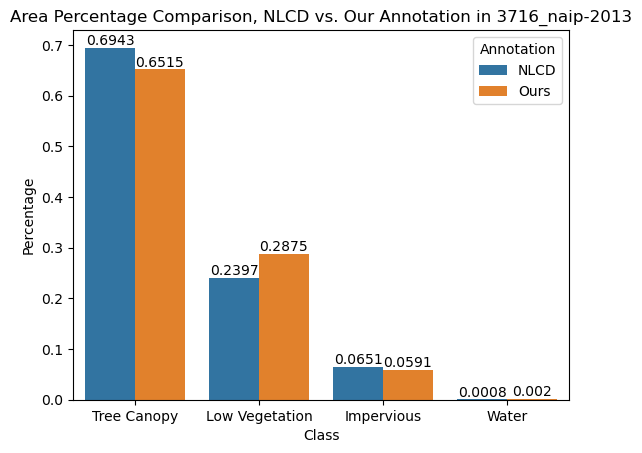

In [31]:
plot_bars(nlcd_percentage_3716_2013, masa_annotated_3716_2013, "3716", "2013")

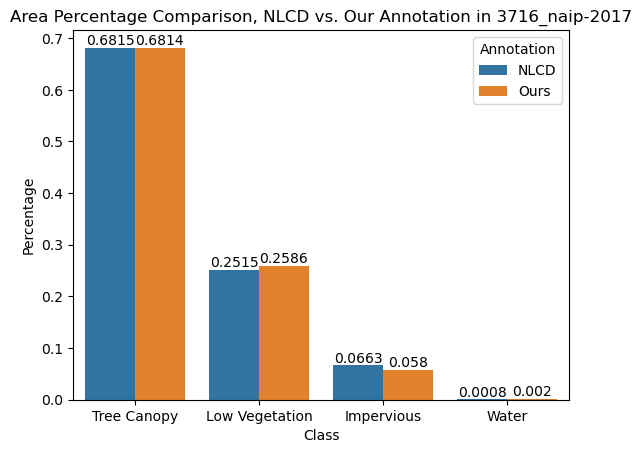

In [32]:
plot_bars(nlcd_percentage_3716_2016, masa_annotated_3716_2017, "3716", "2017")

### Heatmaps

In [42]:
# to plot heatmap of the change of distributions, we need 
# 1. the distribution of each classes in 2013
# 2. the distribution of 2016 class for pixels of each 2013 class

In [49]:
REDUCED_CLASSES = ["Tree Canopy", "Impervious", "Low Vegetation", "Water"]

In [81]:
def plot_heatmaps(df, annotation_2013: dict, category: str, image_number: int) -> None:
    """Plot heatmaps of class distributions in 2013 vs 2017 and save the image
    
    Args:
        df: dataframe read in by geopandas
        annotation_2013: dictionary of class: percentage
        category: either "NLCD" or "Ours"
        image_number: e.g. 3716
    """
    # construct an index column that looks like 'Tree Canopy (69.43%)'...
    index_col = []
    for c in REDUCED_CLASSES:
        index_col.append(f"{c} ({round(annotation_2013[c] * 100, 2)}%)")

    # read the images, here input 2016 instead of 2017 because 
    # NLCD image only has 2016
    img_2016_index = find_image_index(df, image_number, 2016, "label_fn")
    img_2013_index = find_image_index(df, image_number, 2013, "label_fn")
    img_2016 = io.imread(df.loc[img_2016_index, 'label_fn'])
    img_2013 = io.imread(df.loc[img_2013_index, 'label_fn'])
    assert img_2013.shape == img_2016.shape
    
    # calculate the distribution change
    # one-pass algo:
    # iterate through the image, for each class, store the info
    # of what the label of this pixel is in 2013 and what label 
    # of this pixel is going to be in 2016
    # {"Tree Canopy": {"Tree Canopy": ...}, ...}
    distribution_change = {k: {m: 0 for m in REDUCED_CLASSES} for k in REDUCED_CLASSES}
    for i in trange(img_2013.shape[0]):
        for j in range(img_2013.shape[1]):
            label_2013 = reduced_map[img_2013[i][j]]
            label_2016 = reduced_map[img_2016[i][j]]
            distribution_change[label_2013][label_2016] += 1
    # change to percentage
    for k in distribution_change.keys():
        sum_value = sum(distribution_change[k].values())
        for m in distribution_change[k].keys():
            distribution_change[k][m] /= sum_value
    # print(distribution_change)
    
    # construct df by rows, make sure the order is right by 
    # iterating through REDUCED_CLASSES
    heatmap_df = pd.DataFrame.from_records(data=[{m: distribution_change[k][m] for m in REDUCED_CLASSES} for k in REDUCED_CLASSES], 
                                           index=index_col)
    heatmap_df = heatmap_df.round(3)
    # print(heatmap_df)
    
    # plot heatmap
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu")
    ax.set_title("Distribution of Changes between NLCD 2013 and 2016")
    ax.set_xlabel("2016 Class")
    ax.set_ylabel("2013 Class")
    plt.savefig(f"Distribution of Changes between NLCD 2013 and 2016.png", bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [01:15<00:00, 51.26it/s]


{'Tree Canopy': {'Tree Canopy': 0.9809140368718173, 'Impervious': 0.0004065830094222025, 'Low Vegetation': 0.018679380118760504, 'Water': 0.0}, 'Impervious': {'Tree Canopy': 0.0, 'Impervious': 1.0, 'Low Vegetation': 0.0, 'Water': 0.0}, 'Low Vegetation': {'Tree Canopy': 0.0014629467182613986, 'Impervious': 0.0036579209421376867, 'Low Vegetation': 0.9948791323396009, 'Water': 0.0}, 'Water': {'Tree Canopy': 0.0712778048384478, 'Impervious': 0.0, 'Low Vegetation': 0.0, 'Water': 0.9287221951615522}}
                         Tree Canopy  Impervious  Low Vegetation  Water
Tree Canopy (69.43%)           0.981       0.000           0.019  0.000
Impervious (6.51%)             0.000       1.000           0.000  0.000
Low Vegetation (23.97%)        0.001       0.004           0.995  0.000
Water (0.08%)                  0.071       0.000           0.000  0.929


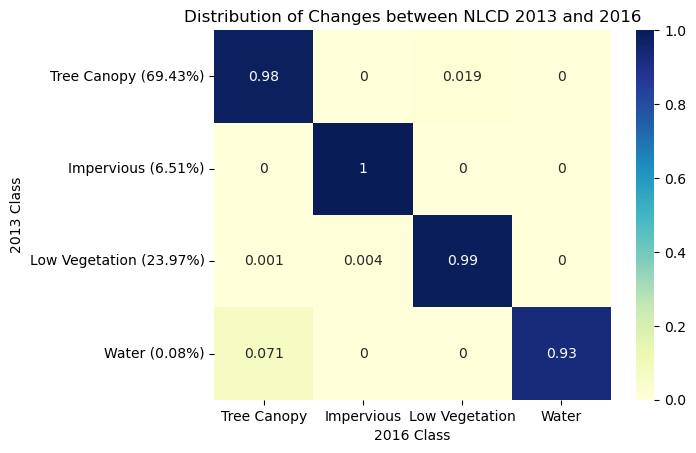

In [76]:
plot_heatmaps(training_both_df, nlcd_percentage_3716_2013, "NLCD", 3716)

In [84]:
def plot_heatmaps_without_diagonal(df, annotation_2013: dict, category: str, image_number: int) -> None:
    """Plot heatmaps of class distributions in 2013 vs 2017 and save the image
    
    Args:
        df: dataframe read in by geopandas
        annotation_2013: dictionary of class: percentage
        category: either "NLCD" or "Ours"
        image_number: e.g. 3716
    """
    # construct an index column that looks like 'Tree Canopy (69.43%)'...
    index_col = []
    for c in REDUCED_CLASSES:
        index_col.append(f"{c} ({round(annotation_2013[c] * 100, 2)}%)")

    # read the images, here input 2016 instead of 2017 because 
    # NLCD image only has 2016
    img_2016_index = find_image_index(df, image_number, 2016, "label_fn")
    img_2013_index = find_image_index(df, image_number, 2013, "label_fn")
    img_2016 = io.imread(df.loc[img_2016_index, 'label_fn'])
    img_2013 = io.imread(df.loc[img_2013_index, 'label_fn'])
    assert img_2013.shape == img_2016.shape
    
    # calculate the distribution change
    # one-pass algo:
    # iterate through the image, for each class, store the info
    # of what the label of this pixel is in 2013 and what label 
    # of this pixel is going to be in 2016
    # {"Tree Canopy": {"Tree Canopy": ...}, ...}
    distribution_change = {k: {m: 0 for m in REDUCED_CLASSES} for k in REDUCED_CLASSES}
    for i in trange(img_2013.shape[0]):
        for j in range(img_2013.shape[1]):
            label_2013 = reduced_map[img_2013[i][j]]
            label_2016 = reduced_map[img_2016[i][j]]
            distribution_change[label_2013][label_2016] += 1
    # change to percentage
    for k in distribution_change.keys():
        # excluding the value itself
        sum_value = sum(distribution_change[k].values()) - distribution_change[k][k]
        for m in distribution_change[k].keys():
            if sum_value == 0:
                distribution_change[k][m] = 0
            else:
                distribution_change[k][m] /= sum_value
    # print(distribution_change)
    
    # construct df by rows, make sure the order is right by 
    # iterating through REDUCED_CLASSES
    heatmap_df = pd.DataFrame.from_records(data=[{m: distribution_change[k][m] for m in REDUCED_CLASSES} for k in REDUCED_CLASSES], 
                                           index=index_col)
    heatmap_df = heatmap_df.round(3)
    # print(heatmap_df)
    
    # plot heatmap
    mask = np.eye(len(heatmap_df))
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", mask=mask)
    ax.set_title("Distribution of Changes between NLCD 2013 and 2016")
    ax.set_xlabel("2016 Class")
    ax.set_ylabel("2013 Class")
    plt.savefig(f"Distribution of Changes between NLCD 2013 and 2016 (2).png", bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [01:42<00:00, 37.71it/s]


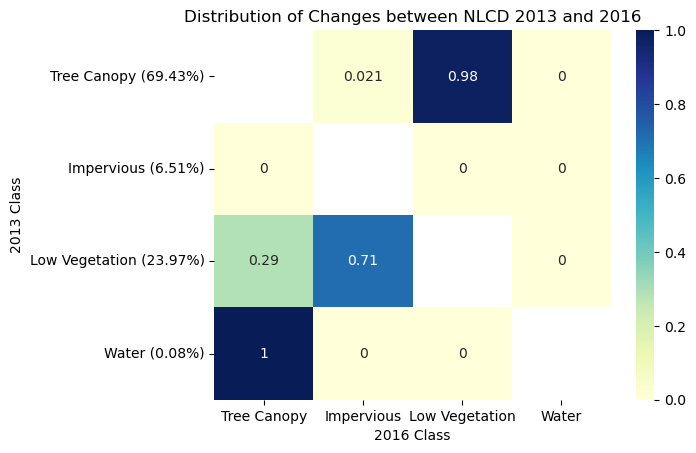

In [85]:
plot_heatmaps_without_diagonal(training_both_df, nlcd_percentage_3716_2013, "NLCD", 3716)

### Then we could only focus on the training data

In [ ]:
def compute_percentage(df, df_row, img_ndarray) -> None:
    """Do one_pass to fill in df columns"""
    for i in range(img_ndarray.shape[0]):
        for j in range(img_ndarray.shape[1]):
            df.loc[df_row, utils.NLCD_CLASS[img_ndarray[i][j]]] += 1
    for class_name in utils.NLCD_CLASS.values():
        df.loc[df_row, class_name] /= (img_ndarray.shape[0] * img_ndarray.shape[1])

In [ ]:
def transform_df(sample_df) -> pd.DataFrame:
    """Transform training_df or val_df such that it one-hot-encodes 
    the percentage of each class in each image, done for the NLCD column"""
    df_copy = sample_df.copy()
    for v in utils.NLCD_CLASS.values():
        df_copy[v] = 0
    for i in range(len(sample_df)):
        img = io.imread(df_copy.loc[i, "label_fn"])
        compute_percentage(df_copy, i, img)
    return df_copy

In [ ]:
def plot_histogram_one_class(sample_df, class_int):
    """Plot distribution of a certain class throughout samples
    
    Args:
        sample_df: either training_df or val_df
        class_int: the integer representing the class
    """
    

In [ ]:
df_copy = training_both_df.copy()
for v in utils.NLCD_CLASS.values():
    df_copy[v] = 0
for i in trange(len(df_copy)):
    img = io.imread(df_copy.loc[i, "label_fn"])
    compute_percentage(df_copy, i, img)
df_copy.to_csv("training_both_encoded.csv")

In [ ]:
# plot a distribution of the percentage of a certain class in a certain image
